In [1]:
import numpy as np
import pandas as pd

# preprocessing 
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string
import gensim  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # bags of words and TF IDF

#split dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import MultiLabelBinarizer 

# analyze result
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix , make_scorer
# cnn
from keras.layers.regularization.dropout import Dropout
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:

# Exploratory analysis of data
data=pd.read_csv("/content/file_dataAug.csv",encoding='unicode_escape')
data.head()

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,0
1,1,"For the last quarter of 2010 , Componenta 's n...",0
2,2,According to the Finnish-Russian Chamber of Co...,0
3,3,The Swedish buyout firm has sold its remaining...,0
4,4,$SPY wouldn't be surprised to see a green close,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10136 non-null  int64 
 1   Sentence    10136 non-null  object
 2   Sentiment   10136 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 237.7+ KB


In [4]:
data.drop(columns=['Unnamed: 0'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10136 entries, 0 to 10135
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   10136 non-null  object
 1   Sentiment  10136 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.5+ KB


In [5]:

data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10074 entries, 0 to 10135
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   10074 non-null  object
 1   Sentiment  10074 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 236.1+ KB


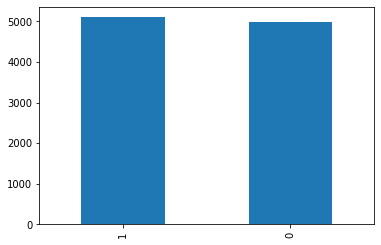

In [6]:
data.Sentiment.value_counts().plot.bar()

In [7]:
# Data preprocessing

# with removal of stopwords

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text_tokenize = re.split('\W+', text)
    text_nostop = [word for word in text_tokenize if word not in stopwords]
    #text_stemm = [ps.stem(x) for x in text_nostop]
    text_lemm = [wn.lemmatize(x) for x in text_nostop]
    return text_lemm

def clean_text_nostop(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text_tokenize = re.split('\W+', text)
    text_lemm = [wn.lemmatize(x) for x in text_tokenize]
    return text_lemm    

data['text_clean'] = data['Sentence'].apply(lambda x: clean_text(x.lower()))
data['text_clean_nostop'] = data['Sentence'].apply(lambda x: clean_text_nostop(x.lower()))
data.head()


,Sentence,Sentiment,text_clean,text_clean_nostop
0,The GeoSolutions technology will leverage Bene...,0,"[geosolutions, technology, leverage, benefon, ...","[the, geosolutions, technology, will, leverage..."
1,"For the last quarter of 2010 , Componenta 's n...",0,"[last, quarter, 2010, componenta, net, sale, d...","[for, the, last, quarter, of, 2010, componenta..."
2,According to the Finnish-Russian Chamber of Co...,0,"[according, finnishrussian, chamber, commerce,...","[according, to, the, finnishrussian, chamber, ..."
3,The Swedish buyout firm has sold its remaining...,0,"[swedish, buyout, firm, sold, remaining, 224, ...","[the, swedish, buyout, firm, ha, sold, it, rem..."
4,$SPY wouldn't be surprised to see a green close,0,"[spy, wouldnt, surprised, see, green, close]","[spy, wouldnt, be, surprised, to, see, a, gree..."


In [8]:
#one hot encoding of label for cnn
y_ohe = pd.get_dummies(data['Sentiment'])

In [9]:
# CLASSIFFIERS

#model_1- Logistic Regression 

def LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = False, stopw=False):
  X = data.sample(frac=1).reset_index(drop= True) # this shuffle data and reset index
  y = data.Sentiment.values
  if bow and stopw:
        count_vec = CountVectorizer(tokenizer = word_tokenize, analyzer=clean_text,token_pattern=None)
  elif TFIDF and stopw:
      count_vec = TfidfVectorizer(tokenizer = word_tokenize, analyzer=clean_text,token_pattern=None)
  elif Ngram and stopw:
      count_vec = CountVectorizer(tokenizer = word_tokenize,analyzer=clean_text, token_pattern=None, ngram_range = (1, 3))
  elif bow:  
       count_vec = CountVectorizer(tokenizer = word_tokenize, analyzer=clean_text_nostop,token_pattern=None)
  elif TFIDF:
       count_vec = TfidfVectorizer(tokenizer = word_tokenize, analyzer=clean_text_nostop,token_pattern=None)
  elif Ngram: 
      count_vec = CountVectorizer(tokenizer = word_tokenize,analyzer=clean_text_nostop, token_pattern=None, ngram_range = (1, 3))   
    
  model=LogisticRegression(solver = 'liblinear')
  skf = StratifiedKFold(n_splits=5)
  lst_accu_stratified=[]
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train=X.iloc[train_index,:]
        X_test=X.iloc[test_index,:]
        y_train=y[train_index]
        y_test=y[test_index]

        Xtrain_countVec = count_vec.fit_transform(X_train['Sentence'])
        Xtest_countVec = count_vec.transform(X_test['Sentence'])
        
        model.fit(Xtrain_countVec,y_train)
        y_pred = model.predict(Xtest_countVec)
        accuracy_precision = precision_score(y_test, y_pred, average='micro')
        accuracy_recall = recall_score(y_test, y_pred, average='micro')
        lst_accu_stratified.append([accuracy_precision,accuracy_recall])

        #print('precision score:', accuracy_precision)
        #print('recall score:', accuracy_recall)
        #print("========================================================")
  print('Overall precision and recall:',np.mean(lst_accu_stratified,axis=0))

In [10]:

# Logistic Regression+ BOW+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = True,TFIDF = False,Ngram = False,stopw=True)
# Logistic Regression+ TFIDF+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = True,Ngram = False,stopw=True)
# Logistic Regression+ Ngram=3+ text without stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = True,stopw=True)

Overall precision and recall: [0.49742142 0.49742142]
Overall precision and recall: [0.49712203 0.49712203]
Overall precision and recall: [0.50645186 0.50645186]


In [11]:

# Logistic Regression+ BOW+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = True,TFIDF = False,Ngram = False)
# Logistic Regression+ TFIDF+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = True,Ngram = False)
# Logistic Regression+ Ngram=3+ text with stopwords
LogReg_bow_tfidf_ngram(data = data,bow = False,TFIDF = False,Ngram = True)

Overall precision and recall: [0.50466531 0.50466531]
Overall precision and recall: [0.49771604 0.49771604]
Overall precision and recall: [0.49027325 0.49027325]


In [12]:
#model_2- Naive Bayes


X = data.sample(frac=1).reset_index(drop= True) # this shuffle data and reset index
y = data.Sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)
# text without stopword
cv=CountVectorizer(analyzer=clean_text)
Xtrain_cv = cv.fit_transform(X_train['Sentence'])
Xtest_cv = cv.transform(X_test['Sentence'])

classifier1=GaussianNB()
classifier1.fit(Xtrain_cv.toarray(),y_train)
y_pred=classifier1.predict(Xtest_cv.toarray())
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")
# text with stopword
cv=CountVectorizer(analyzer=clean_text_nostop)
Xtrain_cv = cv.fit_transform(X_train['Sentence'])
Xtest_cv = cv.transform(X_test['Sentence'])
classifier2=GaussianNB()
classifier2.fit(Xtrain_cv.toarray(),y_train)
y_pred=classifier2.predict(Xtest_cv.toarray())
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")

precision score: 0.49186184994045257
recall score: 0.49186184994045257
precision score: 0.4938467645891227
recall score: 0.4938467645891227


In [13]:
#model_3- Random Forest
X_train,X_test,y_train,y_test=train_test_split(data['text_clean'],data['Sentiment'],test_size=0.25)
w2v_model=gensim.models.Word2Vec(X_train,min_count=1)# Word 2 Vector
vecWords=w2v_model.wv.index2word
X_train_vect=np.array([np.array([w2v_model.wv[i] for i in ls if i in vecWords]) for ls in X_train])
X_test_vect=np.array([np.array([w2v_model.wv[i] for i in ls if i in vecWords]) for ls in X_test])

X_train_vect_avg=[]
for v in X_train_vect:
  if v.size:
    X_train_vect_avg.append(v.mean(axis=0))
  else:
      X_train_vect_avg.append(np.zeros(100,dtype=float))

X_test_vect_avg=[]
for v in X_test_vect:
  if v.size:
    X_test_vect_avg.append(v.mean(axis=0))
  else:
      X_test_vect_avg.append(np.zeros(100,dtype=float))

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_vect_avg,y_train)
y_pred=clf.predict(X_test_vect_avg)
accuracy_precision = precision_score(y_test, y_pred, average='micro')
accuracy_recall = recall_score(y_test, y_pred, average='micro')
print('precision score:', accuracy_precision)
print('recall score:', accuracy_recall)
print("========================================================")          

precision score: 0.6709011512504962
recall score: 0.6709011512504962


In [14]:
## LSTM

In [15]:
## CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(data['Sentence'])
print(X_counts.shape)
#print(count_vect.get_feature_names())
print(count_vect.get_feature_names_out())

(10074, 16004)
['' '0' '00' ... 'Âºo' 'Â¼' 'Ã']


In [16]:

X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.columns = count_vect.get_feature_names()
X_counts_df
     

,,0,00,000,000063,0008,001,002,0025,003,...,zona,zone,zoo,zu,Â,Â³,Â³EUR,Âºo,Â¼,Ã
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10070,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10071,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10072,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:

X = X_counts_df
X.shape,y_ohe.shape

((10074, 16004), (10074, 2))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.10, stratify=y_ohe,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7706, 16004), (1360, 16004), (1008, 16004), (7706, 2), (1360, 2), (1008, 2))

In [19]:
train_x = np.asarray(X_train)
train_y = np.asarray(y_train)
validation_x = np.asarray(X_val)
validation_y = np.asarray(y_val)
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
validation_x = validation_x.reshape((validation_x.shape[0],1,validation_x.shape[1]))
train_x.shape, validation_x.shape
     

((7706, 1, 16004), (1360, 1, 16004))

In [20]:
from keras.layers.regularization.dropout import Dropout
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(1,train_x.shape[2])))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               9693000   
                                                                 
 batch_normalization (BatchN  (None, 150)              600       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               15100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                        

In [21]:
history1=model.fit(train_x,train_y,batch_size=32, epochs=30,verbose=2,validation_data=(validation_x, validation_y ))

Epoch 1/30
241/241 - 6s - loss: 0.4724 - accuracy: 0.7822 - val_loss: 0.5290 - val_accuracy: 0.8221 - 6s/epoch - 24ms/step
Epoch 2/30
241/241 - 2s - loss: 0.2382 - accuracy: 0.9089 - val_loss: 0.3037 - val_accuracy: 0.8890 - 2s/epoch - 8ms/step
Epoch 3/30
241/241 - 2s - loss: 0.1863 - accuracy: 0.9263 - val_loss: 0.2790 - val_accuracy: 0.8971 - 2s/epoch - 8ms/step
Epoch 4/30
241/241 - 2s - loss: 0.1571 - accuracy: 0.9356 - val_loss: 0.3397 - val_accuracy: 0.8941 - 2s/epoch - 8ms/step
Epoch 5/30
241/241 - 2s - loss: 0.1451 - accuracy: 0.9377 - val_loss: 0.3444 - val_accuracy: 0.8993 - 2s/epoch - 8ms/step
Epoch 6/30
241/241 - 2s - loss: 0.1342 - accuracy: 0.9413 - val_loss: 0.3409 - val_accuracy: 0.8919 - 2s/epoch - 8ms/step
Epoch 7/30
241/241 - 2s - loss: 0.1182 - accuracy: 0.9458 - val_loss: 0.4172 - val_accuracy: 0.8978 - 2s/epoch - 8ms/step
Epoch 8/30
241/241 - 2s - loss: 0.1158 - accuracy: 0.9482 - val_loss: 0.3907 - val_accuracy: 0.8868 - 2s/epoch - 8ms/step
Epoch 9/30
241/241 - 2s

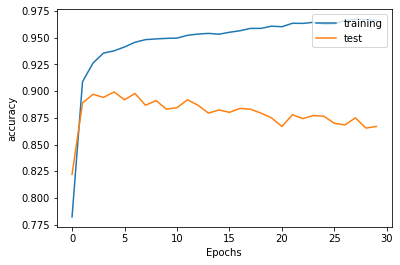

In [22]:

import matplotlib.pyplot as plt
metrics='accuracy'
plt.plot(history1.history[metrics])
plt.plot(history1.history['val_'+ metrics])
plt.xlabel('Epochs')
plt.ylabel(metrics)
plt.legend(['training', 'test'], loc='upper right')
plt.show()

In [23]:

import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

test_x=np.asarray(X_test)
test_x=test_x.reshape((test_x.shape[0],1,test_x.shape[1]))
test_y = np.argmax(np.array(y_test),axis=1)
y_pred = model.predict(test_x)
test_pred=np.argmax(y_pred,axis=1)

32/32 [==============================] - 0s 3ms/step


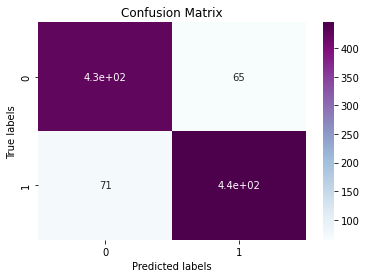

In [24]:

def plot_conf(ypred,y_test):
    cf_matrix = confusion_matrix( ypred,y_test)
    ax= plt.subplot()
    sns.heatmap(cf_matrix,annot=True,ax=ax, cmap="BuPu")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
plot_conf(test_pred,test_y)  

In [25]:
 print(classification_report(test_pred,test_y))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       492
           1       0.87      0.86      0.87       516

    accuracy                           0.87      1008
   macro avg       0.86      0.87      0.87      1008
weighted avg       0.87      0.87      0.87      1008

